In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'vehicle-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5521913%2F9142550%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240930%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240930T232227Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2c526cfa689a0aa209f2e5c2d16cf33aae39a5f05ac180c1926209f219c4c6355fe0b8dfc786c820cb1a62f6168f5eab241474337ae0050474a86cece33dbf117e71a61812905e95a8c82ca864e4b8225887d17860991a6486cf74264d2695a698361af2bdb675ce1f0ec978cd75f6cc3e3af13cc5511be0766b84d9f68f499c5dbdb19d0ca9f8cd2c44017584023569ce589310ed6a9606a9d5c97561afa057f527f80b7d9620057c4106f92abc8a8e0f0095319eafa32aa2a59e0a00cbf9b10583bef97f15457dfbe8c9b2fa8cf74834c54540b3dc6799867073d47cf69f342a7981505662e7254c136ec92768dbeb9514212bd83f3df4965cb753d4a7bec4,try-to-predict:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5666062%2F9348065%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240930%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240930T232227Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3b4d747b144dae7f7ba19ba102f47158f19f0b712652641e62f625010ef5c2b78bdc173a1bb948d00fa9b7c9a2a72a9956f6ecf70a2e573f2554331d9f4cedadfa04dd685247699333f13d3532703fc556b83eba8ab976a94ddd33dc59874d0bc4848f812f841e291a5ab2189bb9287126d91d4e70ccb6ab6f1d53e3f27e737b7a4247ed3068760e76f751e4c0de36b65caf421a780f9a911b111e661962b74a02c0b52249aa7037314735b07a267b5d2d8c7f7f4eb195c4b9fe91667a33da041198a683579a89baca84586c7caee47afb8c2e0fa0763660b553fa7e8cb23783956c2a0c27a9694a616c682a427b383ca1169dd316048f93873d900b299d12f9,new-image:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5666175%2F9348217%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240930%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240930T232227Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Daf45ffce685b2800604a558841c14201dc8367710d9ae712ef8f00e5a8b18886ff28a3b427e8fe307cf4003d14bc73616ace8a97b690f03431f6999cf1cb2115022be3efb5c3655ebf7b5af2539cc278386af77bc09e08898220a236c34c7f900c7d03fa2ccbe4d8642f586c7e90756e738def87354fbf0027607c0df992f360a79a1b10e1b9649932f6e1d107ed012698f1ceb512021ff49b7ff5edbc641dfeea7291c60332df0942ad97d0572a0783281a3265931f986817fb1b3aa57caad9d564af33e34142587aabeb961b27d1c05fa4d5d94a048c778d7d5ae11c36d4bc823b1e7b75d25c403dacdbe1db7faca66a2a96c65929921af43a9f5b8f13b392,vehicle_classification_model/pytorch/default/1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-models-data%2F92176%2F110044%2Fbundle%2Farchive.tar.gz%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240930%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240930T232227Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0d90e1d84f5ddbe8a84e4f68a541fc67332ea699163e6f5b0dd2df43aa18632cfae05ab62cc13ca8409a394dfee375283ce6fa4617136fb1a317c871e2c13fa137914c7118c0d6f781586c121ca0d3dadff0a9954c3eb40702b21ae89361dbbe2a5039a62fecb9acd74b21041e2d34a9e1bea6c85742aea6ae17eaad9433cbe33580cab56b1bb4e751182291d9a1c5b014f35574fa5ec5bb2ce8340f8fcda5a4f17f0055bf42412d431d25bc55bf7fb8b91fcb431e68f42cdd40d78ec279b1eeb6465106ee513322cf3314ed57b3c224ec647c5423c7c615be280ed5212008162c52c8899174b5704191a7534eb13467e7dad17ff9cf9f2c2c6ca5cd59741b1b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 866783573 bytes downloaded
Downloaded and uncompressed: vehicle-classification
[==================================================] 9915 bytes downloaded
Downloaded and uncompressed: try-to-predict
[==================================================] 13353 bytes downloaded
Downloaded and uncompressed: new-image
[==================================================] 96301463 bytes downloaded
Downloaded and uncompressed: vehicle_classification_model/pytorch/default/1
Data source import complete.


# Importing Libraries

In [3]:
import os
import numpy as np
import tempfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import models
from tqdm import tqdm
from torch.optim import Adam, SGD
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Load Dataset & Data Preparation

In [4]:
transforms_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transforms_test = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

#Load Dataset
dataset = datasets.ImageFolder(root= os.path.join('/kaggle/input/vehicle-classification/Vehicles'), transform=transforms_train)

train_x, test_x = train_test_split(list(range(len(dataset))), train_size=0.8, random_state=32)
train_x, val_x = train_test_split(train_x, test_size=0.25, random_state=32)

data_train = Subset(dataset, train_x)
data_val = Subset(dataset, val_x)
data_test = Subset(dataset, test_x)

#Apply transformations
data_train.dataset.transforms = transforms_train
data_val.dataset.transforms = transforms_test
data_test.dataset.transforms = transforms_test

train_loader = DataLoader(data_train, batch_size=32,shuffle=True)
val_loader = DataLoader(data_val, batch_size=32, shuffle=False)
test_loader = DataLoader(data_test, batch_size=32, shuffle=False)

# Model Architecture

In [5]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_features, 256),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(256,7))
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Training & Validation Model

In [7]:
num_epoch = 40
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

for epoch in range(num_epoch):
    #Training
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch: {epoch+1}/{num_epoch}", leave=False):
        #Zero the Parameters Gradient
        optimizer.zero_grad()

        #Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backwar Optimization & Loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        avg_loss_train = running_loss / len(train_loader)
        history['train_loss'].append(avg_loss_train)

    #Validation
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_acc)

    print(f"Epoch: {epoch+1}/{num_epoch}, Train Loss: {avg_loss_train:.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}%")
print("Training Completed")

Epoch: 1/40:  51%|█████▏    | 54/105 [01:23<01:09,  1.37s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1/40, Train Loss: 1.1083, Validation Loss: 0.9054, Accuracy: 68.0680%


Epoch: 2/40, Train Loss: 0.8739, Validation Loss: 0.9286, Accuracy: 67.7102%


Epoch: 3/40, Train Loss: 0.7748, Validation Loss: 0.8200, Accuracy: 71.1986%


Epoch: 4/40, Train Loss: 0.7290, Validation Loss: 0.7107, Accuracy: 76.6547%


Epoch: 5/40, Train Loss: 0.6910, Validation Loss: 0.6539, Accuracy: 79.2487%


Epoch: 6/40, Train Loss: 0.6494, Validation Loss: 0.6258, Accuracy: 79.0698%


Epoch: 7/40, Train Loss: 0.5858, Validation Loss: 0.5575, Accuracy: 83.0948%


Epoch: 8/40, Train Loss: 0.5794, Validation Loss: 0.6030, Accuracy: 80.0537%


Epoch: 9/40, Train Loss: 0.5585, Validation Loss: 0.5338, Accuracy: 82.7370%


Epoch: 10/40, Train Loss: 0.5746, Validation Loss: 0.5638, Accuracy: 82.2004%


Epoch: 11/40, Train Loss: 0.5807, Validation Loss: 0.5420, Accuracy: 81.4848%


Epoch: 12/40, Train Loss: 0.5241, Validation Loss: 0.5117, Accuracy: 83.7209%


Epoch: 13/40, Train Loss: 0.4958, Validation Loss: 0.5487, Accuracy: 81.2165%


Epoch: 14/40, Train Loss: 0.5034, Validation Loss: 0.6078, Accuracy: 81.4848%


Epoch: 15/40, Train Loss: 0.4444, Validation Loss: 0.5082, Accuracy: 82.6476%


Epoch: 16/40, Train Loss: 0.4541, Validation Loss: 0.5127, Accuracy: 82.2004%


Epoch: 17/40, Train Loss: 0.4620, Validation Loss: 0.5512, Accuracy: 81.8426%


Epoch: 18/40, Train Loss: 0.4238, Validation Loss: 0.5176, Accuracy: 83.3631%


Epoch: 19/40, Train Loss: 0.4579, Validation Loss: 0.4957, Accuracy: 84.1682%


Epoch: 20/40, Train Loss: 0.4417, Validation Loss: 0.5067, Accuracy: 83.7209%


Epoch: 21/40, Train Loss: 0.4236, Validation Loss: 0.4904, Accuracy: 85.4204%


Epoch: 22/40, Train Loss: 0.4614, Validation Loss: 0.4697, Accuracy: 84.7048%


Epoch: 23/40, Train Loss: 0.4057, Validation Loss: 0.4527, Accuracy: 84.5259%


Epoch: 24/40, Train Loss: 0.3881, Validation Loss: 0.4730, Accuracy: 85.0626%


Epoch: 25/40, Train Loss: 0.4114, Validation Loss: 0.4413, Accuracy: 84.8837%


Epoch: 26/40, Train Loss: 0.4240, Validation Loss: 0.4596, Accuracy: 84.7943%


Epoch: 27/40, Train Loss: 0.4172, Validation Loss: 0.4353, Accuracy: 84.9732%


Epoch: 28/40, Train Loss: 0.3467, Validation Loss: 0.4658, Accuracy: 85.6887%


Epoch: 29/40, Train Loss: 0.3863, Validation Loss: 0.4719, Accuracy: 85.7782%


Epoch: 30/40, Train Loss: 0.3899, Validation Loss: 0.4199, Accuracy: 85.6887%


Epoch: 31/40, Train Loss: 0.3916, Validation Loss: 0.4127, Accuracy: 86.9410%


Epoch: 32/40, Train Loss: 0.3702, Validation Loss: 0.4513, Accuracy: 85.0626%


Epoch: 33/40, Train Loss: 0.3745, Validation Loss: 0.4022, Accuracy: 87.1199%


Epoch: 34/40, Train Loss: 0.3631, Validation Loss: 0.3454, Accuracy: 88.1932%


Epoch: 35/40, Train Loss: 0.3437, Validation Loss: 0.3674, Accuracy: 87.8354%


Epoch: 36/40, Train Loss: 0.3771, Validation Loss: 0.4344, Accuracy: 86.2254%


Epoch: 37/40, Train Loss: 0.3763, Validation Loss: 0.4165, Accuracy: 86.1360%


Epoch: 38/40, Train Loss: 0.3401, Validation Loss: 0.4113, Accuracy: 87.0304%


Epoch: 39/40, Train Loss: 0.3499, Validation Loss: 0.3816, Accuracy: 87.0304%


Epoch: 40/40, Train Loss: 0.3365, Validation Loss: 0.3831, Accuracy: 85.8676%
Training Completed


# Training & Validation Performance Visualization

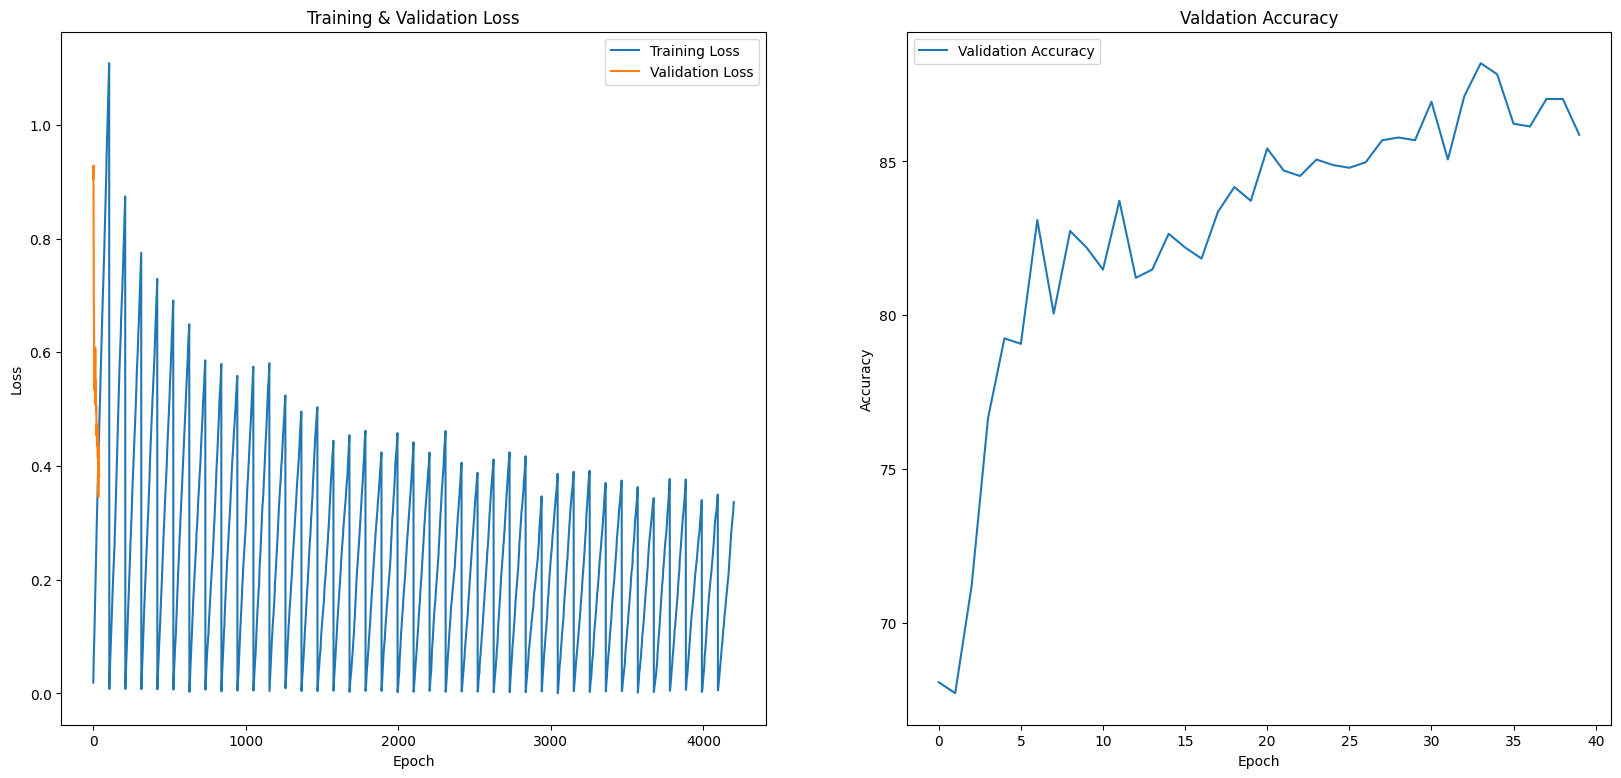

In [8]:
plt.figure(figsize=(20, 9))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title("Valdation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Test Model Performance

In [9]:
def test_evaluate(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc= "Testing", leave=False):
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100 * correct / total

    return test_loss, test_acc

test_loss, test_acc = test_evaluate(model, test_loader)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acuraccy: {test_acc:.4f}")

Test Loss: 0.2574
Test Acuraccy: 90.7871


# Save The Model

In [13]:
#Save Model
#torch.save(model.state_dict(), 'model_no_l2_regularization.pth')
model_save_path = "/content/drive/MyDrive/Colab Notebooks/vehicle_classification_model_v2.pth"
torch.save(model.state_dict(), model_save_path)

# Inference Model

In [14]:
# Load state dict model from file uploaded
model_path = '/content/drive/MyDrive/Colab Notebooks/vehicle_classification_model_v2.pth'
model.load_state_dict(torch.load(model_path))

# Make sure model is in the evaluation mode  to inference
model.eval()

<ipython-input-14-3c776db7841f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

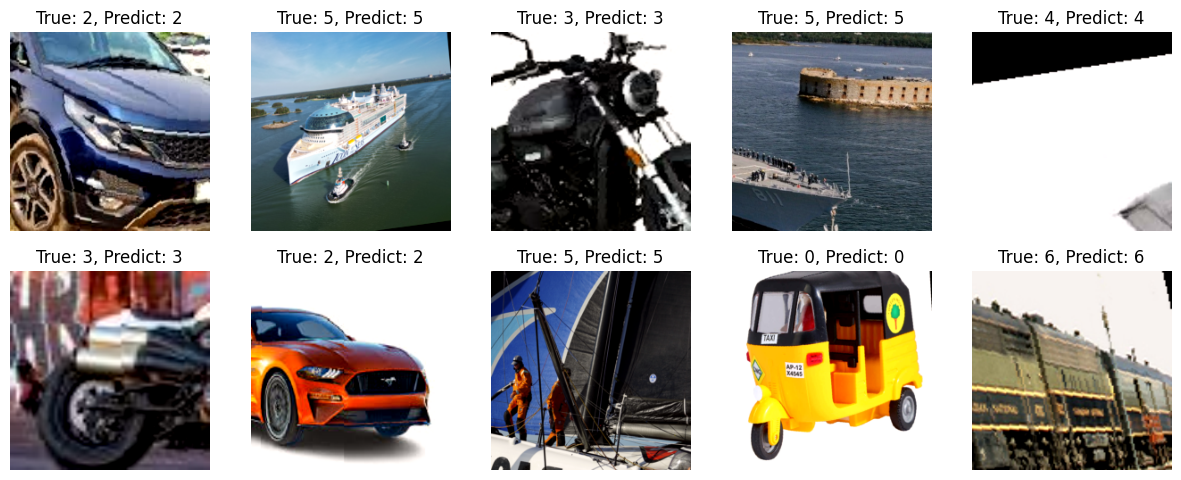

In [15]:
def plot_test_predictions(model, test_loader, num_samples=10):
    model.eval()
    X, y_true, y_pred = [], [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            X.extend(inputs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            if len(X) >= num_samples:
                break

    X = np.array(X[:num_samples]).transpose((0, 2, 3, 1))  # N x H x W x C
    X = X * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    X = np.clip(X, 0, 1)

    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        plt.subplot(5, 5, i + 1)
        plt.imshow(X[i])
        plt.title(f"True: {y_true[i]}, Predict: {y_pred[i]}")
        plt.axis('off')
    plt.show()

plot_test_predictions(model, test_loader, num_samples=10)

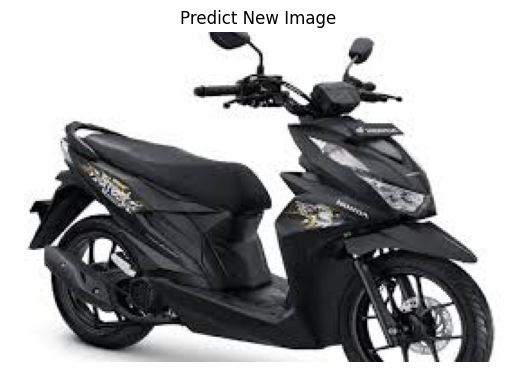

Predicted class: Motorcycle


In [17]:
from PIL import Image
from torchvision import transforms

# Transforms iamge
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()

classes = ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycle', 'Planes', 'Ships', 'Trains']
img = Image.open('/content/sample_data/Data Testing Model 2.jpeg')

plt.imshow(img)
plt.title("Predict New Image")
plt.axis('off')
plt.show()

img = transform(img).unsqueeze(0)

# Predict the image
with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output, 1)
    print(f'Predicted class: {classes[predicted.item()]}')